# Final Exam Part B: Question 1
Daniel Knopp

### Social Media Network Connections & Recommendations

See Below for my initial brainstorming mind-map:

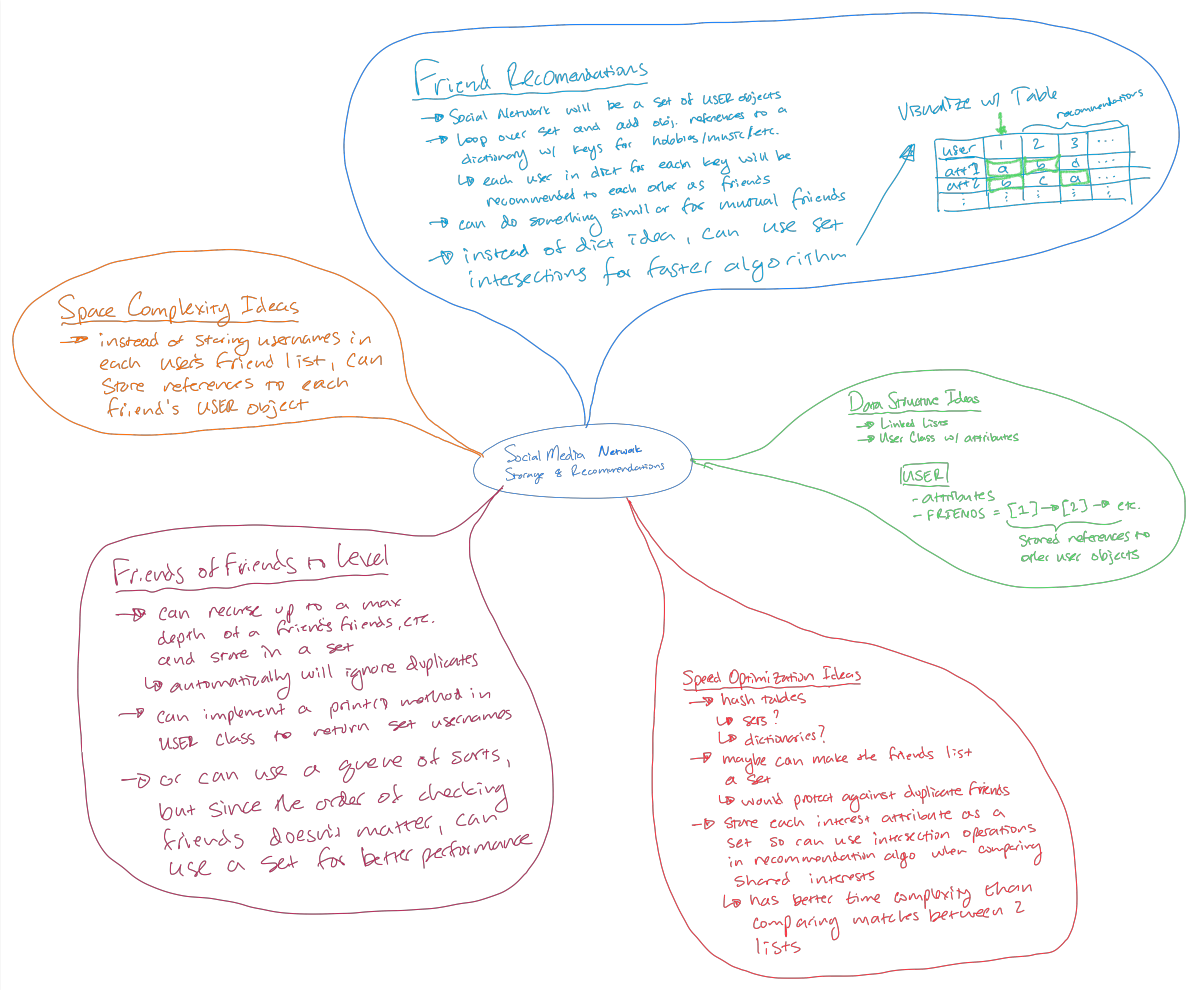

<div class="alert alert-block alert-info">
<b>General Approach and Class Overview</b>

To tackle this problem, I decided that I wanted to decentralize the information so that the storage solution could scale well with size. If I used too many data structures that required contiguous sections of memory, then those data structures would not scale well as we get very large numbers of users in our social network. Similarly though, I need to be careful with the data structure I use to store connections as aften the recommendation algorithms will need to loop over these connections in some way to get friends of friends, mutual friends, etc. - so I have to choose a data structure that balances scalability in space complexity with scalability in time complexity. For this I chose to rely heavily on sets as my primary data structure for most of the stored data. This is primarily because sets scale very well with size due to their ability to use hashing functions - functions that can convert the data itself into an index and typically reduces a high time complexity lookup operation (for example) down to O(1) time complexity. I will explain other places where sets play a key role as I detail the various classes and methods throughout my code. My overall solution contains 2 primary classes:

1. Social Network
    - The social network class represents a collection of users as a whole. I have intentionally not included any connections between users in this class in attempts to maintain space complexity scaling. I want to decentralize the storage and to do that I am storing most of the data for each user in an independant User object which I will detail below. The social network class is responsible for performing any actions that require knowledge of the entire user base as a whole. These class methods are as follows:
        - \_\_init\_\_():
            - Time  Complexity: O(1)
            - Space Complexity: O(n) -> n is number of users
            - Description:      Initializes the social network object. Tracks the current size of the network (number of users), the max index generated (for creating unique IDs), and a set of current users
        - add_user():
            - Time  Complexity: O(1) -> generally adding an element to a set is O(1), but can degrade toward O(n) if there are many collisions from the hashing function
            - Space Complexity: O(n) -> n is the number of users
            - Description:      Adds a new user to the social network
        - remove_user():
            - Time  Complexity: O(1) -> generally removing an element from a set is O(1), but can degrade toward O(n) if there are many collisions from the hashing fucntion
            - Space Complexity: O(n) -> n is the number of users
            - Description:      Removes a user from the social network
        - generate_user_id():
            - Time  Complexity: O(1) -> since a max index value is stored as a private attribute in the class, it is O(1) to generate a new ID by adding 1 to that and incrementing it. This, of course, does have the limitation of not re-using any indices of users who have been deleted
            - Space Complexity: O(1) -> A single new index value is generated
            - Description:      Generates a new user ID by adding 1 to the current \_\_max_id private class attribute. The private attribute is then incremented so that subsequent calls will not collide. As mentioned above, this time complexity savings has the intentional trade-off of not being able to re-use deleted user IDs. If that became desireable then I would recommend an occasionally re-sorting of existing users so that there are no gaps between them and then resetting the private attribute to a value 1 higher than the user IDs - this of course would be a very costly procedure as you would need to update any references to the user ID. I have tried to mitigate this by always passing pointers to objects instead of user ID strings when tracking connections, so that should help if such a re-sorting procedure became necessary at scale. 
        - recommend_friends_by_interest():
            - Time  Complexity: O(n\*a + n\*$log_{2}$(n)) which simplifies to O(n\*$log_{2}$(n)) if we consider the number of attributes, a, to be relatively constant between users. The n\*$log_{2}$(n) conponent comes from the priority sorting that is done at the end of the function, if we decided not to care about suggesting the best matches first, then the complexity would simply be O(n\*a) -> O(n) for constant a. This is because I have used the very fast set interseciton operator which scales like O(a) instead of O(a^2) if I had stored attributes as lists
            - Space Complexity: O(n + a) where n is number of users and comes from the size of the storage dictionary and a is the number of attributes per user which comes from storing the temporary sets used in computing the match score
            - Description:      Finds any other users that share one or more of the same interests in a specific category (hobbies, music, movies) and sorts them by the number of shared interests (highest first). To do this, I loop over all users besides the current user and then use the intersetion operation between the attribute set for the current user and the attribute set for the other user being checked. This operation scales very well with size and I am left with only items that are shared between the users. I can then take the length of this intersection set and use that as a score which indicates how much in common the 2 users have. I then store the user ID and score in a temporary reference dicionary. Finally, after checking all other users, I can sort all the items in the dictionary by the highest score and return a list of user IDs in order. 
        - recommend_mutual_friends():
            - Time  Complexity: The time complexity of this function is identical to that of the recommend_friends_by_interest(). The only difference is instead of a being the number of interests a user has, it is the number of friends a user has in this funciton. 
            - Space Complexity: The space complexity is also identical to the previous method but, again, a represents the average number of friends users have
            - Description:      Finds any other users that share one or more of the same friends and sorts them by the nubmer of shared friends (highest first). This function operates identically to the function above except that I needed to user the get_friends() method instead of the get_attribute() method before I could do my set intersection to compute the score of each other user. I could easily merge these 2 methods since I have chosen to use sets for aall the interest attributes as well as the friends attribute, but since the exam lists these as seperate functions I have chosen to keep them individual for clarity. Similarly to the previuos method, this scales very well with large numbers of users and friends due to the performance gains from set operations. 
        - visualize_social_network():
            - Time  Complexity: O(n \* f) -> n is number of users and f is average number of friends. This is because adding a node and a connection to the graph are all constant time operations and you need to do this once for every node (user) and edge (connection/friend)
            - Space Complexity: O(n + f + n) simplifies to O(n + f). This is because the primary source of space complexity comes from the graph iteslt, which needs to store data for each node (user) and each connection (friend). The position data and node colors are responsible for the other O(n) term but O(2n) simplifies to O(n).
            - Description:      Visualizes the users and all their connections on a graph to clearly visualize the social network. I have also added arguments to let me highlight specific users to help with visualization of the recommendations listed in the methods above as well as friends in the methods listed in the User class below. 
    - As you can see, my solution for the social network scales very well with size. Due to my usage of sets, many of the methods are constant time operations O(1) and if I were to avoid sorting the recommentations based on score, the others are O(n) at worst. Still, if I keep the sorting in, O(n\*$log_{2}$(n)) is generally considered quite good for large scale solutions. 

2. User
    - The user class represents the decentralized storage of user-specific data. This is where all the interests are stored as attributes (hobbies, music, and movies) as well as all the connections between users. I have leaned heavily on using sets instead of lists to store the interest information as I have developed recommendation algorithms that can utilize set operations such as the intersection operation to do quick comparisons of shared interests that scales well time-wise with large sets of interest at scale. For space complexity scaling, I have made sure that my friends 'list' (set) is just a set that contains only references to each other friend object, but not any real data about the friends. This follows in line with the decentralization of data where each user can be stored seperately in memory and is not a part of any contiguous piece of memory (besides the memory needed for storing the set of pointers). An additional advantage that storing a set of pointers gives me is that I can very easily move to a user's friend and do any operations I might need there in a single step - without needing to search the social network for that friend by name. The user-specific class methods are as follows:
        - \_\_init\_\_():
            - Time  Complexity: O(1)
            - Space Complexity: O(a) where a is the number of attributes per interest
            - Description:      Initializes an individual user object. Contains attributes for all interests (hobbies, music, movies) and friends stored as sets. This method also automatically adds the new user to the social network.
        - \_\_str\_\_():
            - Time  Complexity: O(1)
            - Space Complexity: O(1)
            - Description:      Overrides the default string method so that the user ID value is returned as a string (convenient for printing and for use in the network visualization method above).
        - get_attribute():
            - Time  Complexity: O(1)
            - Space Complexity: O(a) or O(f) depending on which attribute is being requested, where a is the number of interests for a given attribute and f is the number of friends
            - Description:      Convenient function to get the attribute of a User object by string. This is helpful for generalizing a lot of the functions to be compatible with any of the various user interests (hobbies, music, movies) and also friends. This primarily serves to simplify code and allow less hard-coding of addtibute related code. 
        - add_connection():
            - Time  Complexity: O(1)
            - Space Complexity: O(1)
            - Description:      Adds a connection between users (becoming friends). When a connection is added from one user to another, the method automatically adds the matching connection to the other user pair. 
        - remove_connection():
            - Time  Complexity: O(1)
            - Space Complexity: O(1)
            - Description:      Removes a connection between users (unfriending). When a connection is removed by one user, the method automatically removes the matching connection from the other user pair.
        - get_friends():
            - Time  Complexity: O(1)
            - Space Complexity: O(f) where f is the number of friends
            - Description:      Returns the set of all the friends of a user.
        - get_friends_to_level(): 
            - Time  Complexity: O(n \* f) in the worst case when the level is high enough to include everyone, where n is number of users and f is average friends per user or O(l \* f^2) where l is the level (l*f represents the number of users that will be checked and the other f is their friends that need to be looped over). 
            - Space Complexity: O(n) in the worst casae when the level is high enough to include everyone or O(l \* f) where f is the average number of friends per user
            - Description:      Returns a set of friends up to a specified level of separation from a user. This method keeps track of users that need to have their friends checked and the corresponding level of separation from the current user. It loops until there are no friends left to check and each time it checks a user who is less than the specified level of separation it adds that user's friends to the users_to_check list and to the set of friends that will be returned. Once a user is checked, then it is added to a users_checked list so that no user is ever checked more than once. The resulting friends list is also a set because it was simpler to use a set to prevent any duplicates (friends shared between friends) rather than adding in specific logic to check that. 
    - As you can see, my solution for the User class also scales very well with size. Due to my usage of sets, many of the methods are constant time operations O(1) similar to in the Social Network class. The method which scales the worst is, of course, the one to get all friends up to a specified level of seperation. I suspect it should be possible to improve upon this time complexity further, since I know I am not using any special algorithm to avoid checking friends of friends who many have already been checked (I'm using conditional statements and the uniqueness property of sets to handle that). This is still a loss of efficiency though as my for loop still needs to loop over those users even though nothing will happen with them. 


</div>

In [1]:
# Import the necessary libraries
import random
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

<div class="alert alert-block alert-info">
Code below is class definition for the Social Network.
</div>

In [2]:
# Create a class for the social network
class Social_Network:

    # Create the initial constructor for the class
    def __init__(self):
        self.__size   = 0
        self.__max_id = 0
        self.users    = set() # Using a set (see default value) to avoid any duplicates and improve performance of lookups

    # Overwrite default len() method to return the number of users in the social network
    def __len__(self):
        return self.__size

    # Create a method to add a user to the social network and increment the size
    def add_user(self, user_object):
        self.users.add(user_object)
        self.__size += 1

    # Create a method to remove a user from the social network and decrement the size
    def remove_user(self, user_object):
        self.users.remove(user_object)
        self.__size -= 1

    # Create a method to generate a unique user ID (starts at 1 and increments by 1 for each new user - limitation is that if a user is removed, the removed ID will not be reused)
    def generate_user_id(self):
        self.__max_id += 1
        return self.__max_id
    
    # Create a method to return the list of users in the social network
    def get_users(self):
        return self.users
    
    # Create a method to get a user by their ID (generally not used in functions because time complexity is O(n), is only here as a convenience for the user to look up a specific user by ID occasionally by hand)
    def get_user_by_id(self, user_id):

        # Loop through all the users in the social network
        for user in self.users:

            # If the user ID matches the user ID passed in, return the user
            if str(user) == user_id:
                return user
    
    # Create a method to recommend friends for a user based on a specific interest attribute (music, movies, hobbies; default = music)
    def recommend_friends_by_interest(self, user_object, attribute='hobbies'):

        # Create a dictionary to store the recommended friends and their matching score
        recommended_friends = {}

        # Loop through all the users in the social network
        for user in self.users:

            # Skip the user if they are the same as the user_object passed in
            if user == user_object:
                continue

            # Compute the match score for the user based on the size of the union of each attribute set (number of matching interests)
            match_score = len(user_object.get_attribute(attribute).intersection(user.get_attribute(attribute)))

            # If the matching score is greater than zero, add the user to the recommended friends dictionary
            if match_score > 0:
                recommended_friends[user] = match_score

        # Return the recommended friends dictionary as a list sorted by the match score in descending order
        return sorted(recommended_friends.items(), key=lambda x: x[1], reverse=True)
    
    # Create a method to recommend mutual friends for a user
    def recommend_mutual_friends(self, user_object):

        # Create a dictionary to store the recommended friends and their matching score
        recommended_friends = {}

        # Loop through all the users in the social network
        for user in self.users:

            # Skip the user if they are the same as the user_object passed in or if they are already an existing friend
            if user == user_object or user in user_object.get_friends():
                continue

            # Compute the match score for the user based on the size of the intersection of the friends sets (number of mutual friends)
            match_score = len(set(user_object.get_friends()).intersection(set(user.get_friends())))

            # If the matching score is greater than zero, add the user to the recommended friends dictionary
            if match_score > 0:
                recommended_friends[user] = match_score

        # Return the recommended friends dictionary as a list sorted by the match score in descending order
        return sorted(recommended_friends.items(), key=lambda x: x[1], reverse=True)
    
    # Create a function to visualize the social network as a graph
    def visualize_social_network(self, current_user=None, highlighted_users=[], pos=None):

        # Create a new graph
        graph = nx.Graph()

        # Loop through all the users in the social network
        for user in self.users:

            # Add the user to the graph
            graph.add_node(str(user))

            # Loop through all the friends of the user
            for friend in user.get_friends():

                # Add the friend to the graph
                graph.add_node(str(friend))

                # Add an edge between the user and the friend
                graph.add_edge(str(user), str(friend))

        # Create a circular layout for the graph
        if not pos: pos = nx.spring_layout(graph, scale=2, center=(0, 0))

        # Draw the graph
        nx.draw(graph, pos, with_labels=True, font_weight='bold')

        # Set the node color for highlighted users to green
        node_colors = ['red' if str(user) == current_user else 'green' if str(user) in highlighted_users else 'cyan' for user in graph.nodes()]

        # Draw the nodes with the specified colors
        nx.draw_networkx_nodes(graph, pos, node_color=node_colors)

        # Show the graph
        plt.show()

        # Return the position of nodes so we can keep the graph layout from changing in subsequent calls if we want
        return pos

<div class="alert alert-block alert-info">
Code below is class definition for Users.
</div>

In [3]:
# Create a user class
class User:

    # Create the initial constructor for the class
    def __init__(self, network, hobbies, music, movies):

        # Initialize the user's attributes
        self.user_id = network.generate_user_id() # gets a new unique user ID from the social network class method
        self.hobbies = set(hobbies)
        self.music   = set(music)
        self.movies  = set(movies)
        self.friends = set() # Using a set (see default value) to avoid any duplicates and improve performance of lookups

        # Add the user to the social network
        network.add_user(self)

    # Overwrite default str() method to return the user ID
    def __str__(self):
        return str(self.user_id)

    # Createa a method to get the user's attribute by name
    def get_attribute(self, attribute):
            
        # If the attribute is friends, return the friends set
        if attribute == 'friends':
            return self.friends
            
        # If the attribute is hobbies, return the hobbies set
        if attribute == 'hobbies':
            return self.hobbies

        # If the attribute is music, return the music set
        elif attribute == 'music':
            return self.music

        # If the attribute is movies, return the movies set
        elif attribute == 'movies':
            return self.movies

        # If the attribute is invalid, return None
        else:
            return None

    # Create a method to add a friend connection (adds a reference to the friend object of each user referencing each other's object)
    def add_connection(self, friend_object):

        # Add the friend object to the current user friends set
        self.friends.add(friend_object)

        # Do the same for the other user's friends set
        friend_object.friends.add(self)

    # Create a method to remove a friend connection (removes a reference to the friend object of each user referencing each other's object)
    def remove_connection(self, friend_object):
            
        # Remove the friend object from the current user friends set
        self.friends.remove(friend_object)

        # Do the same for the other user's friends set
        friend_object.friends.remove(self)

    # Create a method to get friends and return the set
    def get_friends(self):
        return self.friends
    
    # Create a method to get friends up to a certain level of separation
    def get_friends_to_level(self, level=1):

        # If the level is 1, return the current user's friends list and bypass the rest of the function
        if level == 1:
            return self.get_friends()

        # Initialize the set of friends to be the first level friends set
        friends = {friend for friend in self.friends}

        # Initialize a set of tuples representing the users to check the friends of, with the first element being the level and the second element being the user
        users_to_check = {(1, friend) for friend in self.friends}

        # Initialize an empty set of users who have been checked
        users_checked = set()

        # Loop until the users_to_check is empty
        while users_to_check:

            # Get the next user and it's level from the users_to_check set of tuples
            lvl, user = users_to_check.pop()

            # If the level is less than the max level
            if lvl < level:

                # Loop over the user's friends except for the current user
                for friend in user.friends - {self}:

                    # Add the friend to the friends set (will automatically ignore duplicates)
                    friends.add(friend)

                    # If the friend is not in the users_checked set (hasn't been checked yet)
                    if friend not in users_checked:

                        # Add the friend and the new level to the users_to_check set of tuples
                        users_to_check.add((lvl+1, friend))

            # Add the user to the users_checked set
            users_checked.add(user)

        # Return the friends set
        return friends

<div class="alert alert-block alert-info">
Code below is for a helper function that allows me to visualize the entire network as a table. This is only useful for very small numbers of users who also have a small number of friends and interests of each category (hobbies, music, movies). For very large number of users this should absolutely not be used as the table would become very massive and unusable. 
</div>

In [4]:
# Create a helper function to generate a table of all the data in the social network
def tabulate_network(network):

    # Create a list of users to include in the dataframe columns
    users = list(network.get_users())

    # Sort the list based on the numeric user ID
    users.sort(key=lambda x: int(str(x)))

    # Convert the list of users to a list of strings
    columns = [str(user) for user in users]

    # Count the number of friends, hobbies, music, and movies for each user - use the max of each to determine the required number of table rows
    num_friends = len(users[0].get_friends(           ))
    num_hobbies = len(users[0].get_attribute('hobbies'))
    num_music   = len(users[0].get_attribute('music'  ))
    num_movies  = len(users[0].get_attribute('movies' ))

    # Create an empty dataframe with the specified columns and rows
    df = pd.DataFrame(columns=columns, index=[f'friend_{i}' for i in range(num_friends)] + [f'hobby_{i}' for i in range(num_hobbies)] + [f'music_{i}' for i in range(num_music)] + [f'movie_{i}' for i in range(num_movies)])

    # Set the colum name
    df.columns.name = 'user_id:'

    # Fill the dataframe with the user data
    for user in users:

        # Get the user's friends and add them to the dataframe
        friends = user.get_friends()
        for i, friend in enumerate(friends):
            df.loc[f'friend_{i}', str(user)] = str(friend)

        # Get the user's hobbies and add them to the dataframe
        hobbies = user.get_attribute('hobbies')
        for i, hobby in enumerate(hobbies):
            df.loc[f'hobby_{i}', str(user)] = hobby

        # Get the user's music and add them to the dataframe
        music = user.get_attribute('music')
        for i, song in enumerate(music):
            df.loc[f'music_{i}', str(user)] = song

        # Get the user's movies and add them to the dataframe
        movies = user.get_attribute('movies')
        for i, movie in enumerate(movies):
            df.loc[f'movie_{i}', str(user)] = movie

    # Set display options to make the table horizontally scrollable and prevent column abbreviation
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', None, 'display.max_colwidth', None):
        
        # Display the dataframe
        display(df)

<div class="alert alert-block alert-info">
Code below is for a helper function that provides clear visualization of how the recommendation algorithms are working by highlighting the shared interests or mutual friends between the user and the recommendations. Similar to the above function (but a little better), this function would not be good to use for very large number of users with many recommendations as the table would get very large very quickly. 
</div>

In [5]:
# Create a helper function to visualize common interests between a user and their recommendations
def tabulate_recommendations(user, recommendations, attribute):
    
    # Create a list of users to include in the dataframe columns
    columns = [str(user)] + [str(friend) for friend in recommendations]

    # Determine the number of required rows based on the max length of the attribute set for the user and the recommended friends
    num_rows = max(len(user.get_attribute(attribute)), max([len(friend.get_attribute(attribute)) for friend in recommendations]))

    # Create an empty dataframe with the specified columns
    df = pd.DataFrame(columns=columns, index=[f'{attribute}_{i}:' for i in range(1, num_rows+1)])

    # Set the column name
    df.columns.name = 'user_id:'

    # Fill in the dataframe with the user's hobbies and the recommended friends' hobbies, padding with na if necessary
    for i, hobby in enumerate(user.get_attribute(attribute)):
        df.loc[f'{attribute}_{i+1}:', str(user)] = hobby
    for friend in recommendations:
        for i, hobby in enumerate(friend.get_attribute(attribute)):
            df.loc[f'{attribute}_{i+1}:', str(friend)] = hobby

    # Replace NaN values with 'None'
    df = df.fillna('None')

    # Define a function to highlight matching attributes in green
    def highlight_matching_hobbies(value):
        if value in user.get_attribute(attribute):
            return 'background-color: green'
        return ''

    # Apply the highlighting function to the dataframe values
    df_styled = df.style.applymap(highlight_matching_hobbies)

    # Highlight the column name that matches the user in red
    red_col = df_styled.columns.get_loc(str(user))
    df_styled.set_table_styles([{
        'selector': f'.col_heading.col{red_col}',
        'props': 'background-color: red'
    }])

    # Display the dataframe
    display(df_styled)

<div class="alert alert-block alert-info">
<b>Testing the Code Part 1</b>

Now that all the classes and helper functions are defined, it's time to test out how everything is working. For the sake of simplicity, I have hardcoded some lists of common hobbies, music genres, and movie genres that I will be pulling from randomly to generate an example population of users. For my example, I chose to generate a population of 50 users who have 3 interests in each category (hobbies, music, movies). This was chosen jsut as an exmaple and the code below is parametric for any arbitrary number of users and interests per category. The purpose of this section is just to initialize the users and no connections have been established between anyone yet. I have also visualized the small population of users as a graph. Note that this initial layout will change once we make connections in attempt to optimally distribute the nodes in the figure to make things clear to see. 

</div>

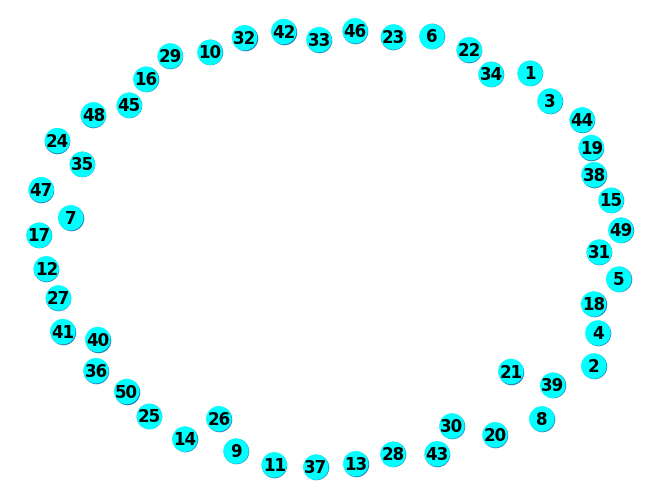

In [16]:
# Let's initialize a new social network
network = Social_Network()

# For testing purposes, let's define a list of 20 each possible hobbies, music, and movies that each test user will randomly choose from
hobbies = ['hiking', 'biking', 'swimming', 'running', 'reading'  , 'writing', 'singing', 'dancing'    , 'cooking'    , 'eating', 'drinking', 'painting', 'drawing', 'sculpting', 'gardening', 'fishing', 'hunting'  , 'camping', 'skiing' , 'snowboarding']
music   = ['rock'  , 'pop'   , 'country' , 'rap'    , 'classical', 'jazz'   , 'blues'  , 'metal'      , 'alternative', 'folk'  , 'punk'    , 'reggae'  , 'soul'   , 'funk'     , 'disco'    , 'techno' , 'house'    , 'trance' , 'dubstep', 'electronic'  ]
movies  = ['action', 'comedy', 'horror'  , 'drama'  , 'thriller' , 'romance', 'western', 'documentary', 'animation'  , 'sci-fi', 'fantasy' , 'mystery' , 'crime'  , 'war'      , 'musical'  , 'history', 'biography', 'sport'  , 'family' , 'adventure'   ]

# Let's add N users (specified in variable below) each with M interests (specified in variable below) to the social network
new_users = 50
num_interests = 3
for i in range(new_users):

    # Create a new user with a random selection of 'num_interests' amount of hobbies, music genres, and movies
    user = User(network, hobbies=random.sample(hobbies, num_interests), music=random.sample(music, num_interests), movies=random.sample(movies, num_interests))
    
# Let's visualize the unconnected social network (not keeping the initial layout since connections haven't been drawn yet)
_ = network.visualize_social_network()


<div class="alert alert-block alert-info">
<b>Testing the Code Part 2</b>

Now that we have a population of users in our social network, we can start adding some connections. For the sake of this example, I have chosen to randomly connect users so that everyone has up to 3 friends maximum. This value is also parametric and can be adjusted in the code below. Depending on how this value relates to the total number of users, some users will have less than this amount of friends, which is to be expected. The code below loops over evey user in the social network expept themselves and any friends they might currently have, randomly chooses a user from the non-friend users, and completes a connection so long as the randomly chosen user does not already have the maxumun number of friends (3 in this example). Once that's complete, I use the helper function to show the entire network's data as a table and also I update the graph visualization now that the connecitons have been made. Please node that if you are viewing the PDF file, there is nothing I can do to make the table format better. In the Jupyter notebook and the HTML file there is the feature of a horizontal scroll bar and I recommend looking at those files to get the full experience. Also, I have stored the position of each node to a variable here so that in all subsequent updates to the graph visualiation I will be able to keep the nodes in the same locations for consistency.

</div>

user_id:,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50
friend_0,38,33,13,17,3,26,5,20,35,11,10,14,21,12,43,50,11,29,40,30,13,12,35,47,11,6,15,32,32,20,28,29,46,45,9,48,19,13,48,19,35,46,33,21,50,47,5,12,19,37
friend_1,7,42,5,31,47,18,30,29,24,25,17,22,38,17,24,40,4,6,37,8,32,6,26,15,10,23,37,31,18,7,38,28,43,36,41,4,50,31,41,16,8,23,15,9,16,42,46,39,28,45
friend_2,27,34,49,36,7,22,1,41,44,14,25,48,3,10,27,45,14,30,49,22,44,20,42,9,43,40,1,49,8,18,4,21,2,2,23,34,27,1,44,26,39,2,25,39,34,33,24,36,3,16
hobby_0,running,reading,camping,painting,swimming,reading,painting,biking,fishing,fishing,writing,writing,cooking,swimming,biking,running,reading,swimming,running,swimming,painting,swimming,running,swimming,camping,swimming,camping,hunting,fishing,swimming,cooking,biking,writing,camping,reading,reading,swimming,cooking,painting,sculpting,dancing,camping,drawing,snowboarding,reading,cooking,writing,swimming,swimming,drawing
hobby_1,drawing,dancing,running,camping,snowboarding,singing,hunting,drawing,drawing,cooking,singing,biking,skiing,biking,camping,singing,running,camping,skiing,biking,camping,reading,skiing,biking,skiing,painting,reading,gardening,skiing,dancing,dancing,hunting,fishing,singing,sculpting,running,cooking,dancing,cooking,hunting,painting,sculpting,gardening,singing,dancing,hunting,cooking,reading,biking,dancing
hobby_2,sculpting,drinking,singing,dancing,skiing,eating,gardening,hunting,hiking,hiking,snowboarding,gardening,sculpting,camping,singing,hunting,drawing,skiing,gardening,hunting,reading,hiking,eating,running,gardening,skiing,cooking,eating,eating,sculpting,running,eating,sculpting,skiing,gardening,eating,drawing,snowboarding,drinking,gardening,singing,hiking,eating,gardening,gardening,eating,swimming,eating,dancing,eating
music_0,dubstep,alternative,rap,trance,techno,punk,trance,trance,electronic,classical,dubstep,rap,classical,pop,alternative,soul,house,soul,dubstep,electronic,alternative,electronic,trance,trance,house,techno,alternative,trance,electronic,trance,alternative,classical,pop,rap,jazz,soul,trance,pop,metal,house,house,trance,rap,alternative,electronic,alternative,classical,alternative,pop,trance
music_1,classical,reggae,jazz,classical,house,country,electronic,classical,jazz,funk,classical,electronic,reggae,techno,rap,reggae,disco,house,pop,disco,rap,techno,classical,pop,punk,disco,techno,house,punk,jazz,country,country,electronic,soul,country,funk,classical,funk,punk,funk,punk,house,electronic,jazz,country,house,electronic,soul,house,house
music_2,blues,funk,dubstep,house,country,rock,punk,soul,blues,blues,rock,dubstep,disco,country,jazz,rock,punk,country,blues,blues,pop,metal,techno,electronic,blues,folk,country,folk,folk,metal,folk,soul,rock,punk,blues,folk,electronic,punk,blues,rock,blues,folk,country,folk,blues,disco,blues,reggae,funk,reggae
movie_0,thriller,romance,thriller,thriller,horror,action,horror,thriller,musical,western,action,comedy,family,animation,musical,history,animation,musical,history,sci-fi,drama,romance,history,history,romance,sport,family,romance,history,horror,romance,history,thriller,family,comedy,sport,thriller,western,sport,thriller,sport,animation,war,romance,western,western,romance,sport,horror,documentary


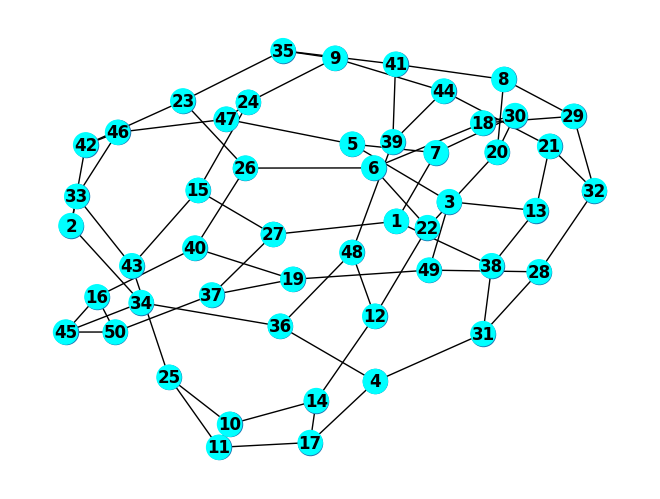

In [17]:
# Let's add up to N random connecitons (specified using variable below) for each user
max_num_connections = 3
for user in network.users:

    # Create a list of all the users in the social network except the current user and the current user's friends (to avoid adding duplicate connections)
    other_users = [other_user for other_user in network.users if other_user != user and other_user not in user.get_friends()]

    # Add random connections for user up to a maximum of N (when a user creates a connection, the matching connection is automatically created for the other user and thus we need to check before adding a new connection)
    while len(user.get_friends()) < max_num_connections:

        # Get a random user from the other_users list
        random_user = random.choice(other_users)

        # Remove the random user from the list of other user choices so that we don't choose the same user twice
        other_users.remove(random_user)
        
        # If the random user does not already have N friends, add the connection
        if len(random_user.get_friends()) < max_num_connections:
            user.add_connection(random_user)

        # If the list of other users is empty, break out of the loop (avoid infinite loop)
        if not other_users:
            break

# Let's show the social network data in a table format (with safegard in place to avoid displaying a table with too many rows)
if len(network) <= 100: tabulate_network(network)

# Let's visualize the social network now that we have connections (up to 3 per user, but some users may have less than 3 connections)
pos = network.visualize_social_network()


<div class="alert alert-block alert-info">
<b>Testing the Code Part 3</b>

Now that our social network and friend connections have been initialized, we can start taking a look at a specific user in the network to see how the various class methods and recommendation algorithms are working. First, let's just simply grab a random user and visualize their current friends. There is both a text summary of the output as well as a graph visualization that has the user highligted in red and all of their current friends highlighted in green on the graph. 

</div>

User 42 has 3 friends: ['46', '23', '2']


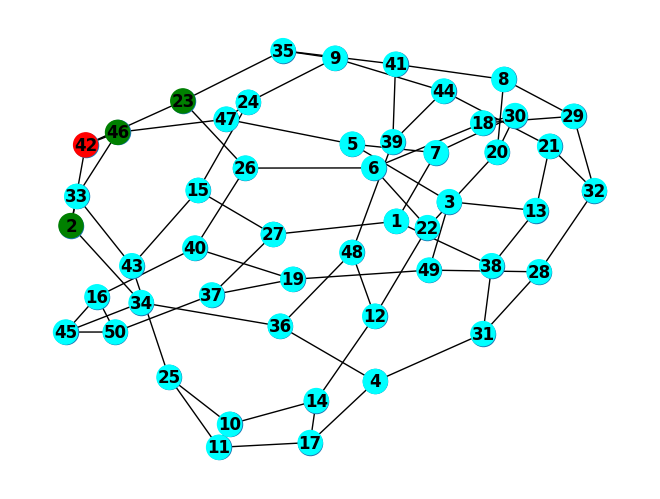

In [29]:
# Let's learn a little more about a random user in the social network, first let's get a random user
user = network.get_user_by_id(str(random.randint(1, len(network))))

# Let's print out the user's ID and their friends
friends = user.get_friends()
print(f'User {user} has {len(friends)} friends: {[str(friend) for friend in friends]}')

# Visualize the social network with the user highlighted in red and friends highlighted in green (not updating the position variable to keep the graph nodes in the same place)
_ = network.visualize_social_network(current_user=str(user), highlighted_users=[str(friend) for friend in friends], pos=pos)

<div class="alert alert-block alert-info">
<b>Testing the Code Part 4</b>

We can also utilize the get_friends_to_level() method to check friends further removed then just 1st level friends. For example, see below for the output and visualization of all friends up to 3 levels removed from the user. Note that this code is also fully parametric and can be adjusted to any level desired, feel free to play around with changing the level variable below if you are viewing the Jupyter notebook version of this document.

</div>

User 42 has 17 friends up to level 2: ['35', '34', '6', '40', '24', '41', '45', '47', '43', '5', '2', '33', '26', '9', '36', '46', '23']


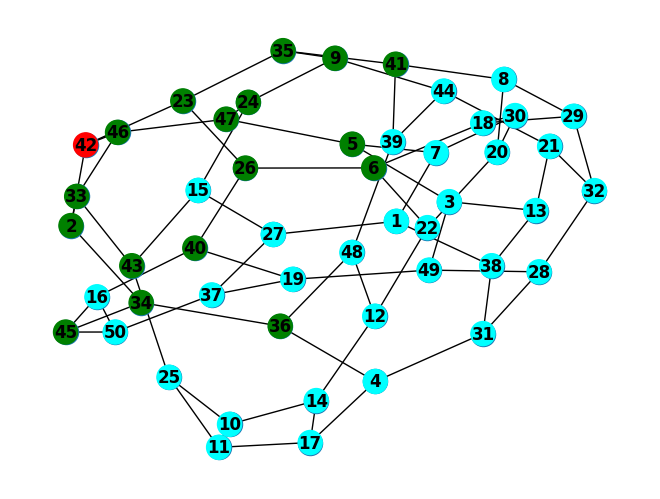

In [30]:
# Let's print out the user's friends up to a certain level of separation
level   = 3
friends = user.get_friends_to_level(level)
print(f'User {user} has {len(friends)} friends up to level 2: {[str(friend) for friend in friends]}')

# Visualize the social network with the user highlighted in red and their friends up to level 2 in green (not updating the position variable to keep the graph nodes in the same place)
_ = network.visualize_social_network(current_user=str(user), highlighted_users=[str(friend) for friend in friends], pos=pos)

<div class="alert alert-block alert-info">
<b>Testing the Code Part 5</b>

Just from looking at the graph shown above, you may be able to guess which users would share the same mutual friends as the user highlighted in red, but I have also built a custom function to do just that. Below is the code to generate friend recommendations for the user based on shared mutual friends with other users. In addition to the same text output and graph visualization as before, I am now also using the tabular visualization helper function I defined earlier. This function provides some inside knowledge on the specific shared friends that each of the recommended users has with the user. I have also included automatic highlighting to make the common friends between the user and recommendations easy to see. Similar to on the graph, the current user ID is highlighted on the table in red. On the graph, you can see that the user is in red just as before, but the green nodes are now the recommended users based on the mutual friends recommendation algorithm discussed in the above seciton.

</div>

User 42 has 5 users with a mutual friend: ['33', '35', '26', '47', '34']


user_id:,42,33,35,26,47,34
friends_1:,46,46,9,6,5,45
friends_2:,23,43,41,23,46,36
friends_3:,2,2,23,40,24,2


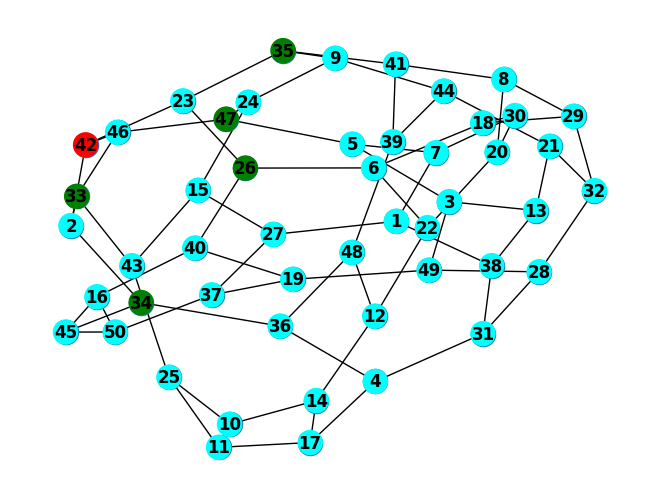

In [31]:
# Now let's recommend mutual friends for the user
recommendations = network.recommend_mutual_friends(user)
print(f'User {user} has {len(recommendations)} users with a mutual friend: {[str(friend) for friend, _ in recommendations]}')

# Let's double check this result by creating a pandas table of friends
tabulate_recommendations(user, [friend for friend, _ in recommendations], 'friends')

# Visualize the social network with the user highlighted in red and their mutual friends in green (not updating the position variable to keep the graph nodes in the same place)
_ = network.visualize_social_network(current_user=str(user), highlighted_users=[str(friend) for friend, _ in recommendations], pos=pos)

<div class="alert alert-block alert-info">
<b>Testing the Code Part 6</b>

Very similarly to creating friend recommendations based on mutual friends, we can also use the recommend_friends_by_interest() method to recommend by any of the interest categories mentioned earlier. In this section, we will focus on recommending users who share the same interest in hobbies as our example user we randomly chose at the beginning of our testing. The following secitons will all share the same standard output and visualization format as the previous code block (Part 5) where there is a general text output summary, a tabular visualization with red highlighting for the current user column and green highlighting for shared interests, and a graph visualization with the user in red and the recommendations in green. 

</div>

User 42 has 18 recommendations based on hobbies: ['35 (1 in common)', '1 (1 in common)', '22 (1 in common)', '14 (1 in common)', '25 (1 in common)', '4 (1 in common)', '10 (1 in common)', '13 (1 in common)', '40 (1 in common)', '30 (1 in common)', '9 (1 in common)', '21 (1 in common)', '33 (1 in common)', '15 (1 in common)', '34 (1 in common)', '27 (1 in common)', '3 (1 in common)', '18 (1 in common)']


user_id:,42,35,1,22,14,25,4,10,13,40,30,9,21,33,15,34,27,3,18
hobbies_1:,camping,reading,running,swimming,swimming,camping,painting,fishing,cooking,sculpting,swimming,fishing,painting,writing,biking,camping,camping,camping,swimming
hobbies_2:,sculpting,sculpting,drawing,reading,biking,skiing,camping,cooking,skiing,hunting,dancing,drawing,camping,fishing,camping,singing,reading,running,camping
hobbies_3:,hiking,gardening,sculpting,hiking,camping,gardening,dancing,hiking,sculpting,gardening,sculpting,hiking,reading,sculpting,singing,skiing,cooking,singing,skiing


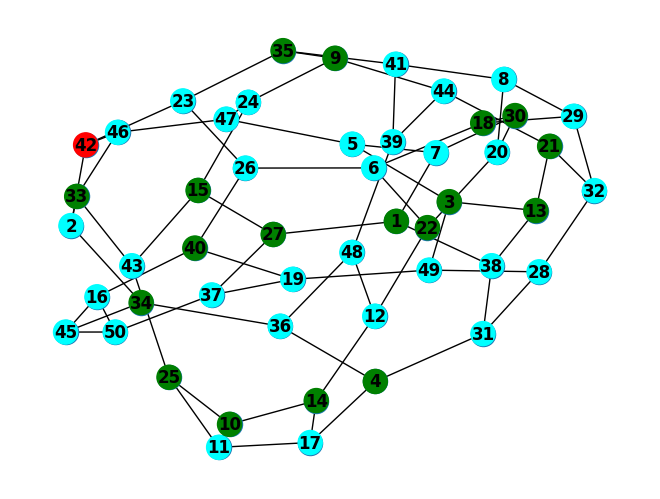

In [32]:
# Now let's recommend friends for the user based on their hobbies
recommendations = network.recommend_friends_by_interest(user, attribute="hobbies")
print(f'User {user} has {len(recommendations)} recommendations based on hobbies: {[f"{friend} ({score} in common)" for friend, score in recommendations]}')

# Let's double check this result by creating a pandas table to see the common hobby interests
tabulate_recommendations(user, [friend for friend, _ in recommendations], attribute='hobbies')

# Visualize the social network with the user highlighted in red and their recommended friends based on hobbies in green (not updating the position variable to keep the graph nodes in the same place)
_ = network.visualize_social_network(current_user=str(user), highlighted_users=[str(friend) for friend, _ in recommendations], pos=pos)

<div class="alert alert-block alert-info">
<b>Testing the Code Part 7</b>

Now let's make similar recommendations for shared interests in music.

</div>

User 42 has 22 recommendations based on music: ['28 (3 in common)', '4 (2 in common)', '50 (2 in common)', '8 (1 in common)', '44 (1 in common)', '25 (1 in common)', '49 (1 in common)', '36 (1 in common)', '26 (1 in common)', '40 (1 in common)', '29 (1 in common)', '30 (1 in common)', '31 (1 in common)', '17 (1 in common)', '5 (1 in common)', '37 (1 in common)', '23 (1 in common)', '24 (1 in common)', '41 (1 in common)', '7 (1 in common)', '46 (1 in common)', '18 (1 in common)']


user_id:,42,28,4,50,8,44,25,49,36,26,40,29,30,31,17,5,37,23,24,41,7,46,18
music_1:,trance,trance,trance,trance,trance,alternative,house,pop,soul,techno,house,electronic,trance,alternative,house,techno,trance,trance,trance,house,trance,alternative,soul
music_2:,house,house,classical,house,classical,jazz,punk,house,funk,disco,funk,punk,jazz,country,disco,house,classical,classical,pop,punk,electronic,house,house
music_3:,folk,folk,house,reggae,soul,folk,blues,funk,folk,folk,rock,folk,metal,folk,punk,country,electronic,techno,electronic,blues,punk,disco,country


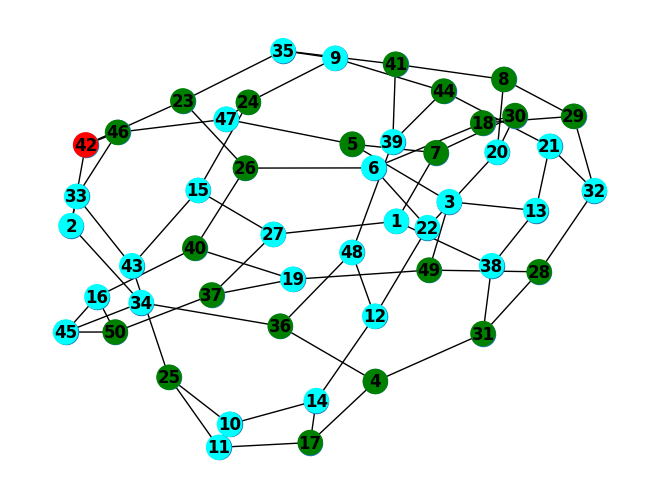

In [33]:
# Now let's recommend friends for the user based on their music interests
recommendations = network.recommend_friends_by_interest(user, attribute="music")
print(f'User {user} has {len(recommendations)} recommendations based on music: {[f"{friend} ({score} in common)" for friend, score in recommendations]}')

# Let's double check this result by creating a pandas table to see the common music interests
tabulate_recommendations(user, [friend for friend, _ in recommendations], attribute='music')

# Visualize the social network with the user highlighted in red and their recommended friends based on music in green (not updating the position variable to keep the graph nodes in the same place)
_ = network.visualize_social_network(current_user=str(user), highlighted_users=[str(friend) for friend, _ in recommendations], pos=pos)

<div class="alert alert-block alert-info">
<b>Testing the Code Part 8</b>

Finally, we can also perform the same recommendations for shared interests in movies.

</div>

User 42 has 18 recommendations based on movies: ['16 (2 in common)', '3 (2 in common)', '11 (1 in common)', '35 (1 in common)', '8 (1 in common)', '14 (1 in common)', '49 (1 in common)', '36 (1 in common)', '28 (1 in common)', '29 (1 in common)', '2 (1 in common)', '31 (1 in common)', '9 (1 in common)', '6 (1 in common)', '21 (1 in common)', '38 (1 in common)', '17 (1 in common)', '15 (1 in common)']


user_id:,42,16,3,11,35,8,14,49,36,28,29,2,31,9,6,21,38,17,15
movies_1:,animation,history,thriller,action,comedy,thriller,animation,horror,sport,romance,history,romance,romance,musical,action,drama,western,animation,musical
movies_2:,action,drama,drama,sci-fi,musical,animation,war,action,drama,comedy,musical,western,animation,action,mystery,biography,drama,family,western
movies_3:,drama,action,action,crime,action,documentary,fantasy,documentary,thriller,action,drama,drama,western,war,fantasy,mystery,fantasy,sci-fi,action


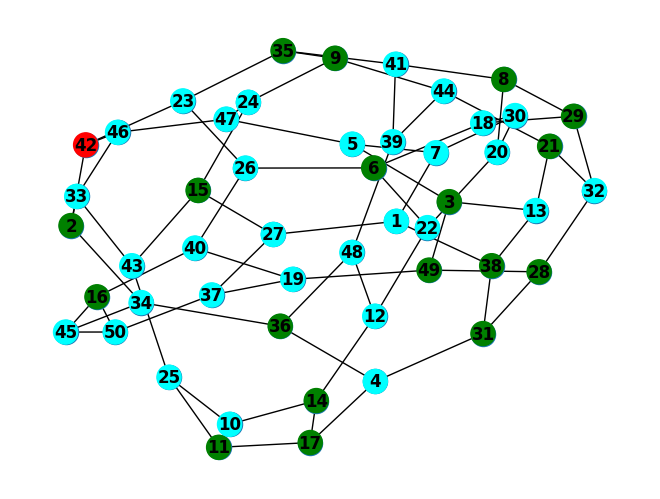

In [34]:
# Finally, let's recommend friends for the user based on their movie interests
recommendations = network.recommend_friends_by_interest(user, attribute="movies")
print(f'User {user} has {len(recommendations)} recommendations based on movies: {[f"{friend} ({score} in common)" for friend, score in recommendations]}')

# Let's double check this result by creating a pandas table to see the common movie interests
tabulate_recommendations(user, [friend for friend, _ in recommendations], attribute='movies')

# Visualize the social network with the user highlighted in red and their recommended friends based on movies in green (not updating the position variable to keep the graph nodes in the same place)
_ = network.visualize_social_network(current_user=str(user), highlighted_users=[str(friend) for friend, _ in recommendations], pos=pos)